# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
from skimage.exposure import rescale_intensity
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
trajectiories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
masks_dir = None  #current_dir.parents[1].joinpath('DataBases','masks_for_sim_cell')

In [3]:
# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [4]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 8 # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 100     # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 40     # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 0.2    # PLEASE TEST MIN 0.1 MAX 2

In [5]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 0 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'
dataframe_format='long'

In [6]:
particle_size = 5 # spot size for the simulation and tracking.
elongation_rate = 5
initiation_rate = 0.03

In [7]:
intensity_scale_ch0 = 100
intensity_scale_ch1 = 100
intensity_scale_ch2 = 100

In [8]:
particle_detection_size = particle_size

## Running the simulations

In [19]:
def fun_simulated_cells(current_dir,trajectiories_dir, video_dir,masks_dir=None,number_of_simulated_cells=3,number_spots_per_cell=80,simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1,path_to_rSNAPsim= None, path_to_save_output='temp',intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video,dataframe_format=dataframe_format,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2):
    spot_size = particle_size
    spot_sigma = 2
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
        
    # Loading trajectories from file
    ssa_trajectories = np.load(str(trajectiories_dir))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        ouput_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        #path_files = [ ouput_directory_name+'/'+f for f in list_files_names ] # creating the complete path for each file
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        video_path = path_files[counter]        
        video = imread(str(video_path)) 
        # Loading the mask image
        if not (masks_dir is None):
            mask_image=imread(masks_dir.joinpath('mask_cell_shape_'+str(counter)+'.tif'))    
        else:
            mask_image=None 
        counter +=1
        if counter>=len(path_files):
            counter =0
        random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
        random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
        simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec]
        simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec]
        # Simulations for intensity
#        ssa1 = rss.ssa_solver(n_traj = number_spots, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
#        simulated_trajectories = ssa1.intensity_vec
#        ssa2 = rss.ssa_solver(n_traj = number_spots, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
#        simulated_trajectories_blue = ssa2.intensity_vec
        # simulated trajectories for the green and blue channels
#        simulated_trajectories_ch2 = simulated_trajectories
#        simulated_trajectories_ch3 = simulated_trajectories_blue
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        _ , _, _ = rsp.SimulatedCell( base_video=video, mask_image=mask_image, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=None, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=1,frame_selection_empty_video=frame_selection_empty_video,dataframe_format=dataframe_format,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path


In [10]:
# running the simulation
start = timer()
ouput_directory_name = fun_simulated_cells(current_dir,trajectiories_dir,video_dir,masks_dir=masks_dir,number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video,dataframe_format=dataframe_format,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')

Time to generate simulated data: 91  sec


In [11]:
ouput_directory_name

PosixPath('/home/luisub/Desktop/rsnaped/notebooks/Simulated_Cell/temp/Simulation_V2__ns_100_diff_0_2')

In [12]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos_original = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [13]:
# Rescaling images
rescale_video = False
if rescale_video == True:
    list_videos = []
    number_channels = list_videos_original[0].shape[-1]
    number_z_slices = list_videos_original[0].shape[0]
    for i in range (0,nimg ):
        temp_img = np.zeros_like(list_videos_original[0])
        for j in range(0,number_channels):
            temp_img[:,:,:,j] =  np.asarray( [ rescale_intensity(list_videos_original[i][z,:,:,j], in_range='image', out_range='dtype')  for z in range (0, number_z_slices)]  )
        list_videos.append(temp_img)
else:
    list_videos = list_videos_original

In [14]:
# Reads the dataframes
list_files_dfnames = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.csv') in f], key=str.lower)  # reading all tif files in the folder
list_files_dfnames.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files_df = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_dfnames ] # creating the complete path for each file
list_df_real_positions = [pd.read_csv(f) for f in  path_files_df] # List with all the videos

## Display results as images

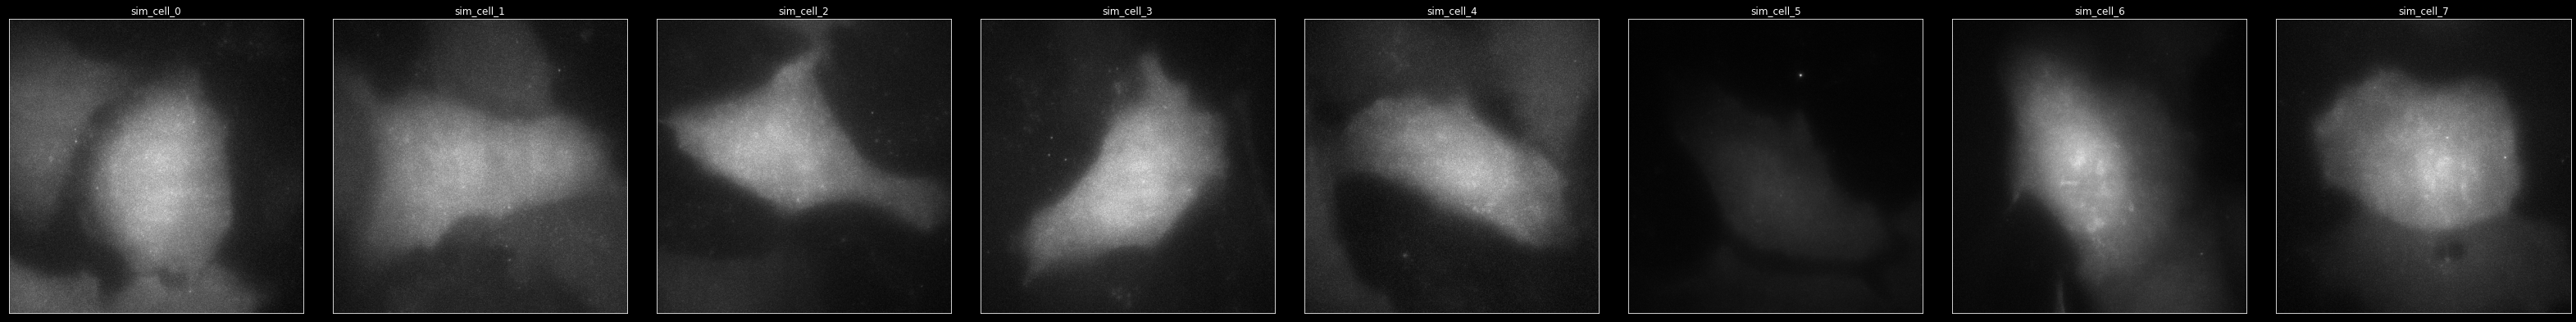

In [15]:
# Showing the simulated images
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =0,selected_timepoint= 0,normalize=0,individual_figure_size=7).plot()

In [16]:
# Extracting the number of real simulations from folder name
sel_timepoint = 0

path_str = str(ouput_directory_name)                    # path
ind_str_start = path_str.find('_ns_') +4                # start index in string
ind_str_end = path_str.find('_diff')                    # end index in string
max_nspots = int(path_str[ind_str_start:ind_str_end])   # number of spots per cell

#Pre-alocating memory
SNR_r = np.zeros((nimg,max_nspots)) # prealocating memory for SNR
SNR_g = np.zeros((nimg,max_nspots)) # prealocating memory for SNR
SNR_b = np.zeros((nimg,max_nspots)) # prealocating memory for SNR

for i in range(0,nimg):
    for j in range (0,max_nspots):
        file_name = str(ouput_directory_name.joinpath('sim_cell_'+str(i)+'_df.csv'))
        df_intensities_real = pd.read_csv(file_name)  
        SNR_r[i,j] = df_intensities_real[df_intensities_real['particle'] ==j].SNR_red.values[sel_timepoint]        
        SNR_g[i,j] = df_intensities_real[df_intensities_real['particle'] ==j].SNR_green.values[sel_timepoint]  
        SNR_b[i,j] = df_intensities_real[df_intensities_real['particle'] ==j].SNR_blue.values[sel_timepoint]  
SNR_r_flat= SNR_r.flatten()
SNR_g_flat= SNR_g.flatten()
SNR_b_flat= SNR_b.flatten()
print(np.mean(SNR_r_flat),np.mean(SNR_g_flat), np.mean(SNR_b_flat)   )

0.5856049789846821 5.816380637568649 nan


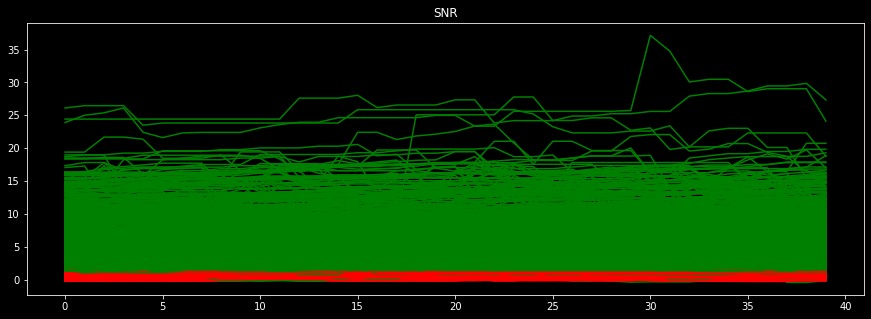

In [17]:
plt.figure(figsize=(15,5))
for i in range(0,nimg):
    for j in range (0,max_nspots):
        file_name = str(ouput_directory_name.joinpath('sim_cell_'+str(i)+'_df.csv'))
        df_intensities_real = pd.read_csv(file_name)  
        sim_snr_r = df_intensities_real[df_intensities_real['particle'] ==j].SNR_red.values[:]        
        sim_snr_g = df_intensities_real[df_intensities_real['particle'] ==j].SNR_green.values[:]  
        sim_snr_b = df_intensities_real[df_intensities_real['particle'] ==j].SNR_blue.values[:]  
        plt.plot(sim_snr_r,color='r')
        plt.plot(sim_snr_g,color='g')
        plt.plot(sim_snr_b,color='b')  
plt.title('SNR')
plt.show()

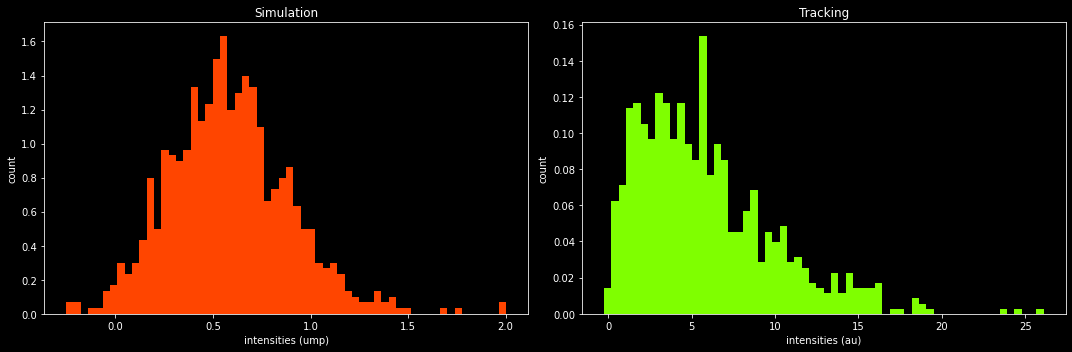

In [18]:
# plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(SNR_r_flat,bins=60,density=True, stacked=True, color='orangered' )     
axes[0].set(title='Simulation')
axes[0].set(xlabel='intensities (ump)')
axes[0].set(ylabel='count')

axes[1].hist(SNR_g_flat,bins=60,density=True, stacked=True, color='chartreuse' )     
axes[1].set(title='Tracking')
axes[1].set(xlabel='intensities (au)')
axes[1].set(ylabel='count')

#axes[2].hist(SNR_b_flat,bins=60,density=True, stacked=True, color='cyan' )     
#axes[2].set(title='Image')
#axes[2].set(xlabel='intensities (au)')
#axes[2].set(ylabel='count')
plt.tight_layout()